## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

In [145]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = sorted(glob.glob('camera_cal/calibration*.jpg'))

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Distortion Correction

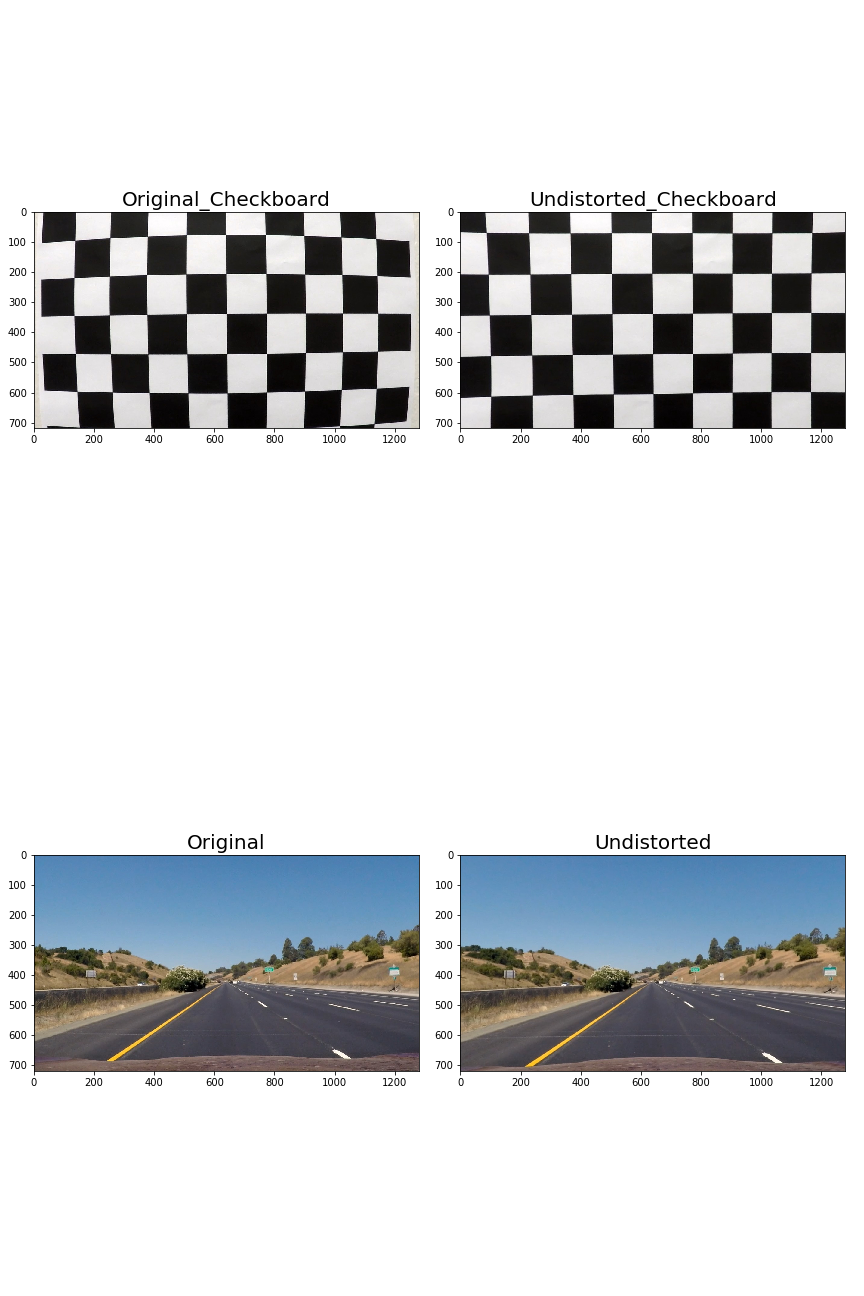

In [146]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 18.0)
# Take the object points and image points and calculate the dist and mtx parameters for camera calibration.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)
# performs the image distortion correction and returns the undistorted image
img_cam = mpimg.imread('camera_cal/calibration1.jpg')
undist_cam = cv2.undistort(img_cam, mtx, dist, None, mtx)
img = mpimg.imread('test_images/straight_lines1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
# mpimg.imsave('test_images/straight_lines1_undist.jpg',undist)
# Plot the result
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
f.tight_layout()

ax1.imshow(img_cam)
ax1.set_title('Original_Checkboard', fontsize=20)

ax2.imshow(undist_cam)
ax2.set_title('Undistorted_Checkboard', fontsize=20)

ax3.imshow(img)
ax3.set_title('Original', fontsize=20)

ax4.imshow(undist)
ax4.set_title('Undistorted', fontsize=20)
plt.show()

## PERSPECTIVE WARP

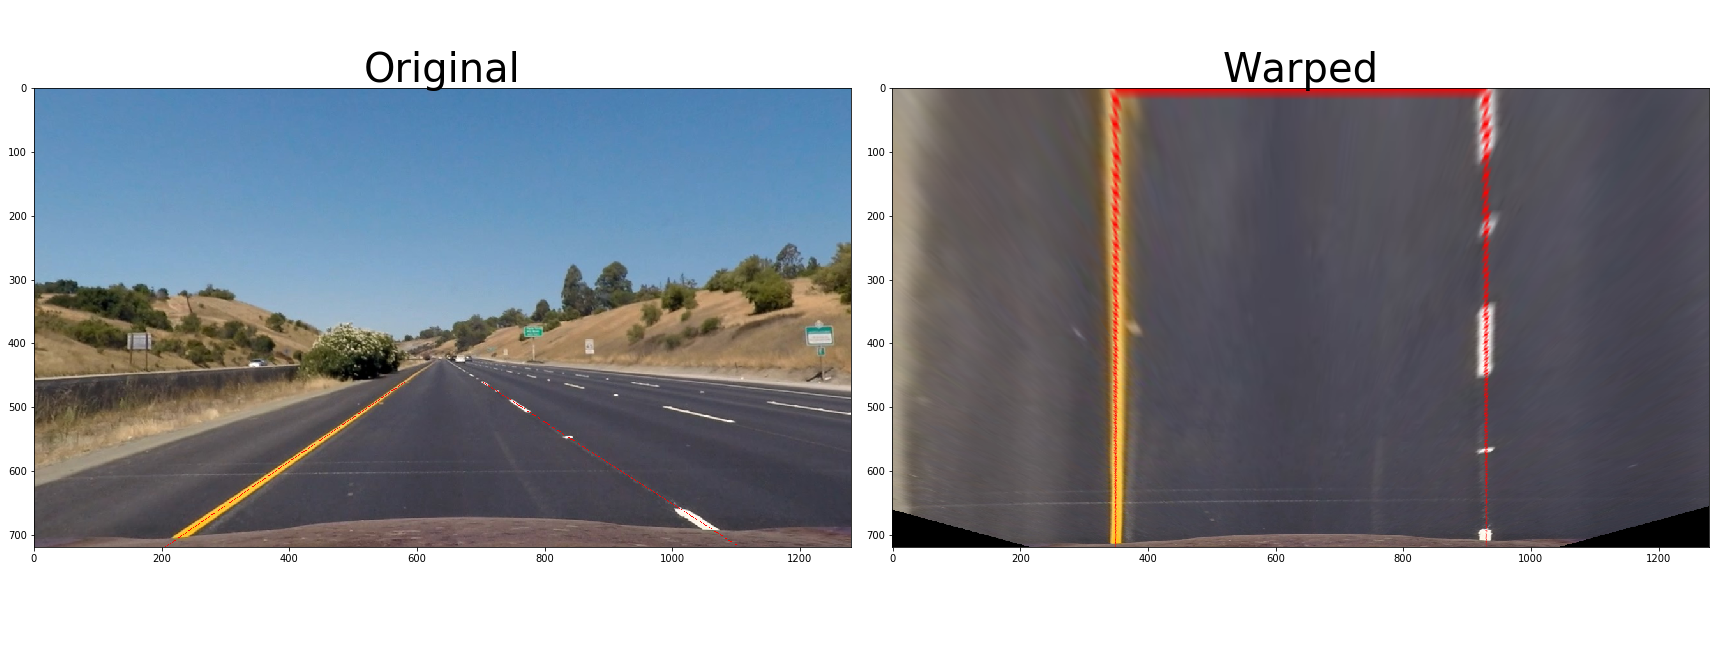

In [147]:
src_1 = np.float32([[581,461], [702,461], [1105,720], [205,720]])


cv2.line(undist, tuple(src_1[0]), tuple(src_1[1]), color=[255,0,0], thickness=1)
cv2.line(undist, tuple(src_1[1]), tuple(src_1[2]), color=[255,0,0], thickness=1)
cv2.line(undist, tuple(src_1[2]), tuple(src_1[3]), color=[255,0,0], thickness=1)
cv2.line(undist, tuple(src_1[3]), tuple(src_1[0]), color=[255,0,0], thickness=1)

img_size = (undist.shape[1],undist.shape[0])

offset_x = 350
dst_1 = np.float32([[offset_x,0], [img_size[0]-offset_x,0], [img_size[0]-offset_x,img_size[1]], [offset_x,img_size[1]]])

M = cv2.getPerspectiveTransform(src_1,dst_1)
Minv = cv2.getPerspectiveTransform(dst_1,src_1)

warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Warped', fontsize=40)
plt.show()

## Filter

In [148]:
def filter_pipeline(img, s_thresh=(180, 255), v_thresh = (180,255), \
                    sx_thresh=(15, 255), sxv_thresh = (15,255), sxs_thresh=(15,255), \
                    mask_vertices=np.array([[[10, 720], [440, 350], [840, 350], [1270, 720]]])):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
    mask = np.uint8(np.zeros_like(img[:,:,0]))
    cv2.fillPoly(mask, mask_vertices, (1))

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1

    # Threshold s_x gradient
    sobelx_s = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx_s = np.absolute(sobelx_s) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx_s = np.uint8(255*abs_sobelx_s/np.max(abs_sobelx_s))
    sxsbinary = np.zeros_like(scaled_sobelx_s)
    sxsbinary[(scaled_sobelx_s >= sxs_thresh[0]) & (scaled_sobelx_s <= sxs_thresh[1])] = 1

    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold hsv value channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1

    # Threshold sobel magnitude
    mag_thresh = (20,255)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
    abs_sobely = np.absolute(sobely)
    gradmag = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1

    # Threshold sobel y
    sy_thresh = (70,255)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1

    # Threshold sobel direction
    dir_thresh = (-1.5, -0.9 , 0.9, 1.5)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[((direction >=dir_thresh[0]) & (direction <=dir_thresh[1]))| (direction >=dir_thresh[2]) & (direction <=dir_thresh[3])] = 1
    dir_binary = np.uint8(dir_binary)

    # Threshold sobel hsv-value-sobel-x
    sobelx_v = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx_v = np.absolute(sobelx_v) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx_v = np.uint8(255*abs_sobelx_v/np.max(abs_sobelx_v))
    sxvbinary = np.zeros_like(scaled_sobelx_v)
    sxvbinary[(scaled_sobelx_v >= sxv_thresh[0]) & (scaled_sobelx_s <= sxv_thresh[1])] = 1



    combined_binary_masked = cv2.bitwise_and(cv2.bitwise_or(cv2.bitwise_and(s_binary,sxsbinary), \
                                                            cv2.bitwise_and(s_binary,v_binary),\
                                                            cv2.bitwise_and(v_binary,sxvbinary),\
                                                            cv2.bitwise_and(sxbinary,cv2.bitwise_not(sybinary)))\
                                             ,mask)
    result = np.dstack(( combined_binary_masked, combined_binary_masked, combined_binary_masked)) * 255

    font = cv2.FONT_HERSHEY_DUPLEX
    Null = np.zeros_like(l_channel)

    text = 'lane_detect_masked'
    lane_detect_masked = np.dstack(( combined_binary_masked, combined_binary_masked, combined_binary_masked)) * 255
    cv2.putText(lane_detect_masked, text, (40,70), font, 1.5, (0,255,255), 2, cv2.LINE_AA)
    cv2.polylines(lane_detect_masked,[mask_vertices],False,(255,255,0))

    sxbinary_channel = np.dstack(( Null, sxbinary, Null)) * 255
    text = 'Lightness_Sobel_X_BINARY'
    cv2.putText(sxbinary_channel, text, (40,70), font, 1.5, (0,255,255), 2, cv2.LINE_AA)

    sxsbinary_channel = np.dstack(( sxsbinary, sxsbinary, Null)) * 255
    text = 'Saturation_Sobel_X_BINARY'
    cv2.putText(sxsbinary_channel, text, (40,70), font, 1.5, (0,255,255), 2, cv2.LINE_AA)

    sobel_binary = cv2.bitwise_and(sxbinary,cv2.bitwise_not(sybinary))
    sobel_binary_channel = np.dstack(( sobel_binary, sobel_binary, Null)) * 255
    text = 'Lightness_Sobel_X & -Sobel_y BINARY'
    cv2.putText(sobel_binary_channel, text, (40,70), font, 1.5, (0,255,255), 2, cv2.LINE_AA)

    mag_channel = np.dstack(( mag_binary, Null, mag_binary)) * 255
    text = 'MAG_BINARY'
    cv2.putText(mag_channel, text, (40,70), font, 1.5, (0,255,255), 2, cv2.LINE_AA)

    dir_binary_channel = np.dstack(( Null, cv2.bitwise_and(v_binary,s_binary), Null)) * 255
    text = 'cv2.bitwise_and(v_binary,s_binary)'
    cv2.putText(dir_binary_channel, text, (40,70), font, 1.5, (0,255,255), 2, cv2.LINE_AA)

    s_binary_channel = np.dstack(( Null, Null, s_binary)) * 255
    text = 'Saturation_BINARY'
    cv2.putText(s_binary_channel, text, (40,70), font, 1.5, (0,255,255), 2, cv2.LINE_AA)

    v_binary_channel = np.dstack(( Null, Null, v_binary)) * 255
    text = 'HSV_Value_BINARY'
    cv2.putText(v_binary_channel, text, (40,70), font, 1.5, (0,255,255), 2, cv2.LINE_AA)

    origin_img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    black = np.zeros_like(img)
    color_binary_up = np.concatenate((s_binary_channel, v_binary_channel, mag_channel), axis=1)
    color_binary_mid = np.concatenate((sxsbinary_channel, sxbinary_channel, sobel_binary_channel), axis=1)
    color_binary_down = np.concatenate((lane_detect_masked, origin_img, dir_binary_channel), axis=1)
    color_binary = np.concatenate((color_binary_up, color_binary_mid, color_binary_down), axis=0)
    color_binary = cv2.cvtColor(color_binary,cv2.COLOR_BGR2RGB)
    color_binary = cv2.resize(color_binary,(1280,720))

    return color_binary,result

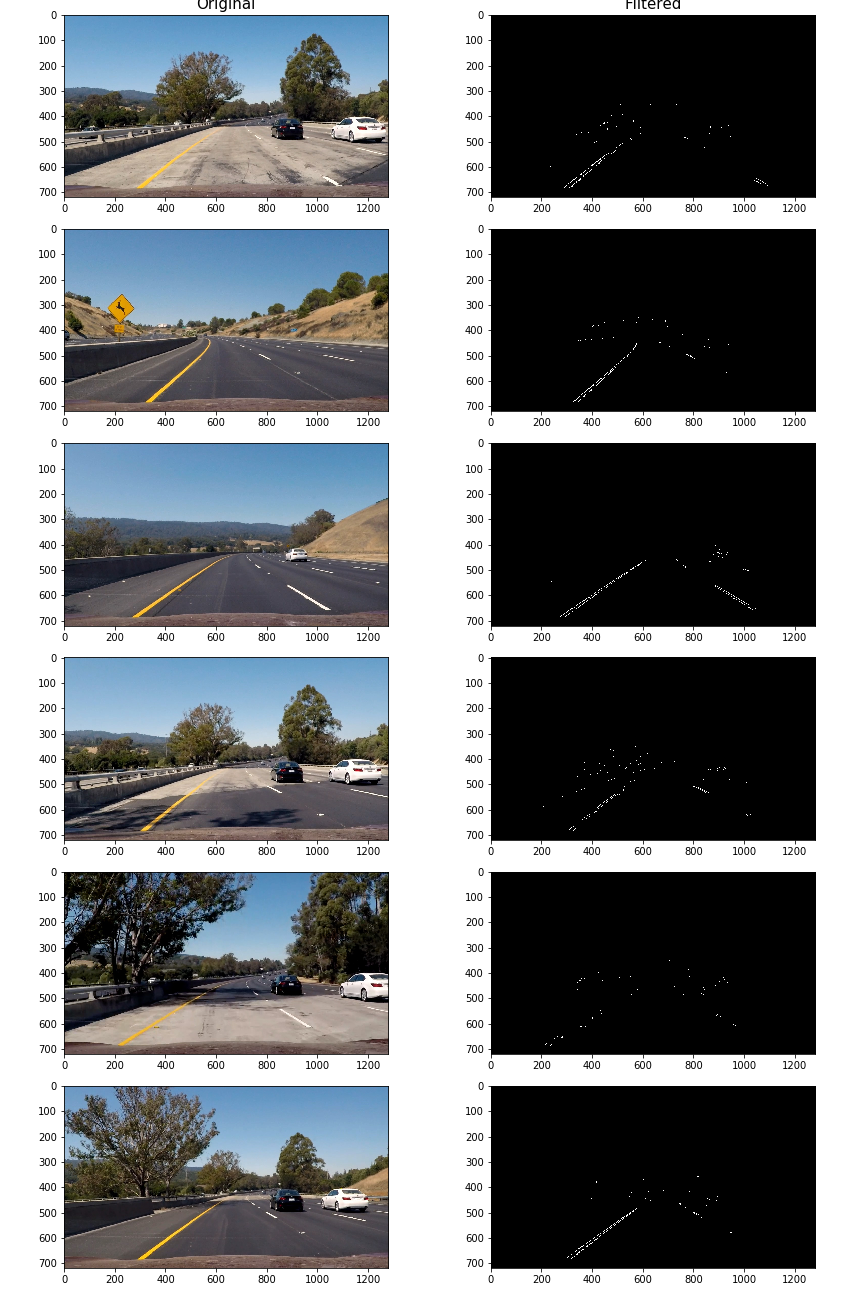

In [149]:

# Make a list of test images
test_images = sorted(glob.glob('test_images/test*.jpg'))

fname0 = test_images[0]
test_image0 = mpimg.imread(fname0)
_,filtered_image0 = filter_pipeline(test_image0)

fname1 = test_images[1]
test_image1 = mpimg.imread(fname1)
_,filtered_image1 = filter_pipeline(test_image1)

fname2 = test_images[2]
test_image2 = mpimg.imread(fname2)
_,filtered_image2 = filter_pipeline(test_image2)

fname3 = test_images[3]
test_image3 = mpimg.imread(fname3)
_,filtered_image3 = filter_pipeline(test_image3)

fname4 = test_images[4]
test_image4 = mpimg.imread(fname4)
_,filtered_image4 = filter_pipeline(test_image4)

fname5 = test_images[5]
test_image5 = mpimg.imread(fname5)
_,filtered_image5 = filter_pipeline(test_image5)

# Plot the result
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12)) = plt.subplots(6, 2)
f.tight_layout()

ax1.imshow(test_image0)
ax1.set_title('Original', fontsize=15)
ax2.imshow(filtered_image0)
ax2.set_title('Filtered', fontsize=15)
ax3.imshow(test_image1)
ax4.imshow(filtered_image1)
ax5.imshow(test_image2)
ax6.imshow(filtered_image2)
ax7.imshow(test_image3)
ax8.imshow(filtered_image3)
ax9.imshow(test_image4)
ax10.imshow(filtered_image4)
ax11.imshow(test_image5)
ax12.imshow(filtered_image5)

plt.show()


## Define Lane Class

In [150]:
class Lane():
    def __init__(self,memorylen=5,curvature_tolerance=5000,lane_wide=1.3,Parallel=1.3,SanitySwitch=True):
        self.left_fit_container = []
        self.right_fit_container = []
        self.left_fit = [None,None,None]
        self.right_fit = [None,None,None]
        self.left_fit_m = [None,None,None]
        self.right_fit_m = [None,None,None]
        self.leftCurvature = None
        self.rightCurvature = None
        self.Curvature = None
        self.deviation = None
        self.memorylen = memorylen
        self.curvature_tolerance = curvature_tolerance
        self.lane_wide = lane_wide
        self.Parallel = Parallel
        self.detected = True
        self.SanitySwitch = SanitySwitch


    def SanityCheck(self,left_fit_m_current,right_fit_m_current):
        if self.SanitySwitch == False:
            return True
        # Curvature Check
        leftCurvature, rightCurvature,_,_ = self.cal_curvature(left_fit_m_current,right_fit_m_current)
        if np.abs(leftCurvature-rightCurvature) > self.curvature_tolerance:
            return False
        # Wideness Check
        ploty = np.linspace(0, 30, 100)
        plotx_left = left_fit_m_current[0]*ploty**2 + left_fit_m_current[1]*ploty + left_fit_m_current[2]
        plotx_right = right_fit_m_current[0]*ploty**2 + right_fit_m_current[1]*ploty + right_fit_m_current[2]
        Horizontal_Distance = np.abs(plotx_left-plotx_right)
        if min(Horizontal_Distance) < self.lane_wide:
            return False
        # parallel Check
        ratio = max(Horizontal_Distance)*1./min(Horizontal_Distance)
        if ratio > self.Parallel:
            return False
        else:

            return True

    def fit_convert_pixel2m(self,left_fit,right_fit):
        # Generate x and y values along fitted lines and convert them from pixels to meters.
        ploty = np.linspace(0, 720-1, 720)
        left_fitx =  left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Fit polynom
        left_fit_m = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_m = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        return left_fit_m,right_fit_m

    def update_fit(self,left_fit,right_fit):
        # Convert lane parameters from pixels to meters.
        left_fit_m_current,right_fit_m_current = self.fit_convert_pixel2m(left_fit,right_fit)
        # Check if the currently detected curve is reasonable
        self.detected = self.SanityCheck(left_fit_m_current,right_fit_m_current)
        # Set the weighted factor for current and previous curve parameters.
        update_weight_list = np.linspace(self.memorylen, 1, self.memorylen)
        update_weight_list = update_weight_list/np.sum(update_weight_list)
        if self.detected == True:
            # Memory Stack full, current curve replace oldest curve
            if len(self.left_fit_container) == self.memorylen:
                self.left_fit_container.pop()
                self.left_fit_container.insert(0,left_fit)
                self.left_fit = np.matmul(np.array(self.left_fit_container).T ,np.array(update_weight_list))
            else:
                # Memory stack not full, add current curve
                self.left_fit_container.insert(0,left_fit)
                update_weight = np.linspace(len(self.left_fit_container), 1, len(self.left_fit_container))
                update_weight = update_weight/np.sum(update_weight)
                self.left_fit = np.matmul(np.array(self.left_fit_container).T , np.array(update_weight))

            if len(self.right_fit_container) == self.memorylen:
                self.right_fit_container.pop()
                self.right_fit_container.insert(0,right_fit)
                self.right_fit = np.matmul(np.array(self.right_fit_container).T , np.array(update_weight_list))
            else:
                self.right_fit_container.insert(0,right_fit)
                update_weight = np.linspace(len(self.right_fit_container), 1, len(self.right_fit_container))
                update_weight = update_weight/np.sum(update_weight)
                self.right_fit = np.matmul(np.array(self.right_fit_container).T , np.array(update_weight))
            self.left_fit_m, self.right_fit_m = self.fit_convert_pixel2m(self.left_fit,self.right_fit)
#         else:
#             print("ERROR")


    def cal_curvature(self,left_fit_cr,right_fit_cr):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = 720*ym_per_pix
        # Calculate the new radii of curvature
        leftCurvature = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        rightCurvature = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        Curvature = (leftCurvature + rightCurvature)/2.
        # left right lane position
        left_lane_pos  = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
        right_lane_pos = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
        # diviate from center in meters
        deviation = (1280*xm_per_pix)/2. - (right_lane_pos + left_lane_pos)/2.
        return leftCurvature,rightCurvature,Curvature,deviation

    def update_curvature(self):
        self.leftCurvature, self.rightCurvature, self.Curvature, self.deviation = self.cal_curvature(self.left_fit_m, self.right_fit_m)



## Lane Detection

In [151]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    # count_left_above = sum(y < 720/3 for y in lefty)
    # count_left_under = sum(y > (720*2)/3 for y in lefty)
    # count_right_above = sum(y < 720/3 for y in righty)
    # count_right_under = sum(y > (720*2)/3 for y in righty)
    # if (count_left_above<10) or (count_left_under<10):
    #     left_fit_1 = np.polyfit(lefty,leftx,1)
    #     left_fit = [0,left_fit_1[0],left_fit_1[1]]
    # else:
    #     left_fit = np.polyfit(lefty,leftx,2)
    #
    # if (count_right_above<10) or (count_right_under<10):
    #     right_fit_1 = np.polyfit(righty,rightx,1)
    #     right_fit = [0,right_fit_1[0],right_fit_1[1]]
    # else:
    #     right_fit = np.polyfit(righty,rightx,2)
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # # Colors in the left and right lane regions
    # out_img[lefty, leftx] = [255, 0, 0]
    # out_img[righty, rightx] = [0, 0, 255]

    # Plot the polynomial lines onto the image
    left_pts = np.array([np.dstack((left_fitx,ploty))], np.int32)
    left_pts = left_pts.reshape((-1,1,2))
    right_pts = np.array([np.dstack((right_fitx,ploty))], np.int32)
    right_pts = right_pts.reshape((-1,1,2))
    cv2.polylines(out_img,[left_pts],False,(0,255,255),5)
    cv2.polylines(out_img,[right_pts],False,(0,255,255),5)

    Lane_pts = np.zeros_like(out_img)
    Lane_pts[lefty,leftx] = (0,0,255)
    Lane_pts[righty,rightx] = (255,0,0)

    return out_img,left_pts,right_pts,left_fit, right_fit, Lane_pts

## Define funtions to write text on images 

In [152]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [153]:
def processImage(img, lane):
    # Return result videos
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    process_img, result = filter_pipeline(undist)
    warped = cv2.warpPerspective(result, M, img_size, flags=cv2.INTER_LINEAR)
    # if (lane.left_fit[0] == None or lane.right_fit[0] == None):
    #     detect,left_pts,right_pts, lane.left_fit, lane.right_fit, lane.left_fit_m, lane.right_fit_m = fit_polynomial(warped[:,:,1])
    # else:
    #     detect,left_pts,right_pts, lane.left_fit, lane.right_fit, lane.left_fit_m, lane.right_fit_m  = search_around_poly(warped[:,:,1],lane)
    detect,left_pts,right_pts, left_fit_cur, right_fit_cur, Lane_pts = fit_polynomial(warped[:,:,1])
    lane.update_fit(left_fit_cur, right_fit_cur)
    lane.update_curvature()
    left_fit = lane.left_fit
    right_fit = lane.right_fit
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_pts = np.array([np.dstack((left_fitx,ploty))], np.int32)
    left_pts = left_pts.reshape((-1,1,2))
    right_pts = np.array([np.dstack((right_fitx,ploty))], np.int32)
    right_pts = right_pts.reshape((-1,1,2))

    right_pts = np.flipud(right_pts)
    pts = np.vstack((left_pts, right_pts))
    warp_zero = np.zeros_like(warped).astype(np.uint8)

    cv2.polylines(warp_zero,[left_pts],False,(0,255,255),5)
    cv2.polylines(warp_zero,[right_pts],False,(0,255,255),5)

    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    Lane_pts = cv2.warpPerspective(Lane_pts, Minv, (img.shape[1], img.shape[0]))
    newwarp = cv2.warpPerspective(warp_zero, Minv, (img.shape[1], img.shape[0]))
    result_detect = cv2.addWeighted(undist, 1, Lane_pts, 1, 0)
    result_detect = cv2.addWeighted(result_detect, 1, newwarp, 0.3, 0)
    result_detect = draw_data(result_detect,lane.Curvature,lane.deviation)

    return result_detect

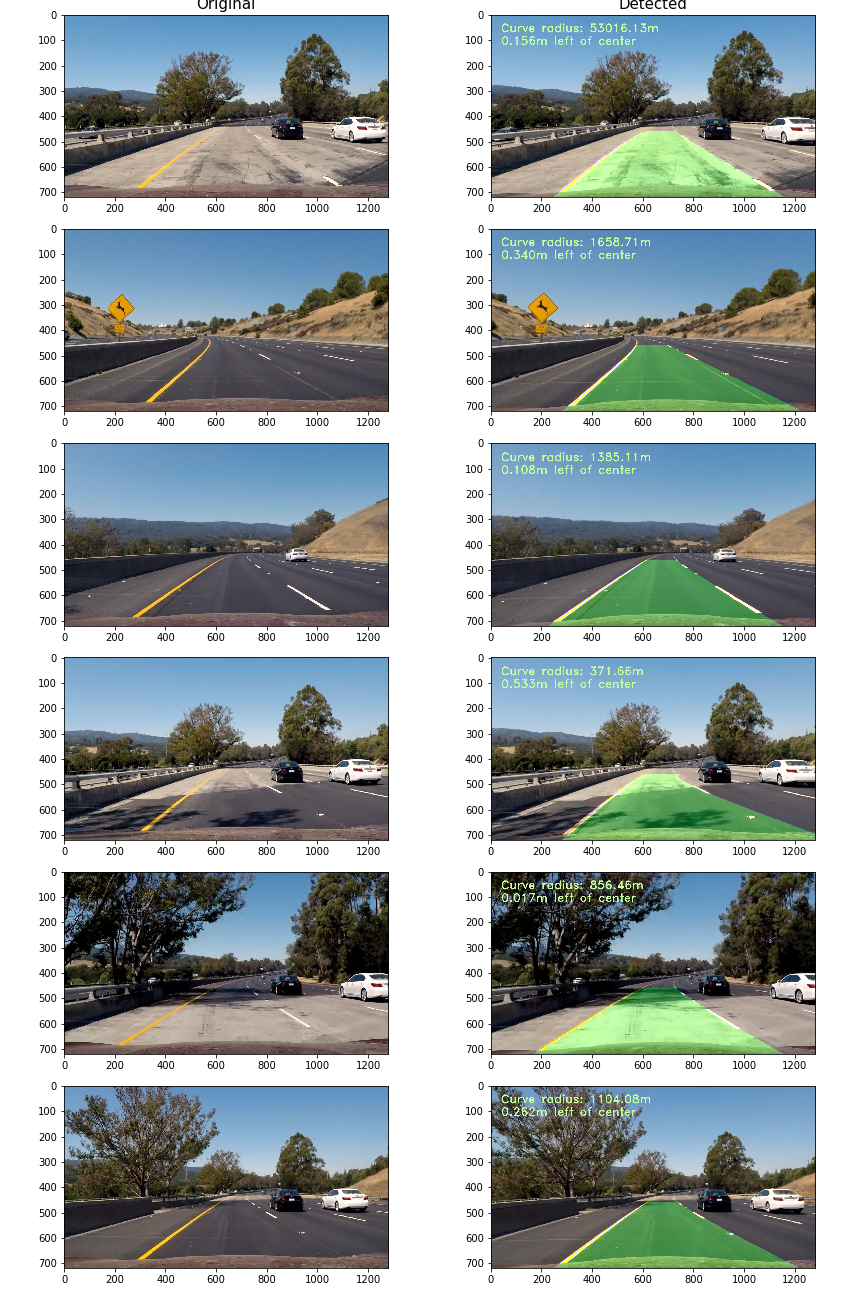

In [154]:
# # Make a list of test images
# test_images = sorted(glob.glob('test_images/test*.jpg'))
lane = Lane(SanitySwitch=False)
# fname0 = test_images[0]
# test_image0 = mpimg.imread(fname0)
test_result0 = processImage(test_image0,lane)
mpimg.imsave('output_images/test_result1.jpg',test_result0)

# fname1 = test_images[1]
# test_image1 = mpimg.imread(fname1)
lane = Lane()
test_result1 = processImage(test_image1,lane)
mpimg.imsave('output_images/test_result2.jpg',test_result1)

# fname2 = test_images[2]
# test_image2 = mpimg.imread(fname2)
lane = Lane()
test_result2 = processImage(test_image2,lane)
mpimg.imsave('output_images/test_result3.jpg',test_result2)

# fname3 = test_images[3]
# test_image3 = mpimg.imread(fname3)
lane = Lane()
test_result3 = processImage(test_image3,lane)
mpimg.imsave('output_images/test_result4.jpg',test_result3)

# fname4 = test_images[4]
# test_image4 = mpimg.imread(fname4)
lane = Lane()
test_result4 = processImage(test_image4,lane)
mpimg.imsave('output_images/test_result5.jpg',test_result4)

# fname5 = test_images[5]
# test_image5 = mpimg.imread(fname5)
lane = Lane()
test_result5 = processImage(test_image5,lane)
mpimg.imsave('output_images/test_result6.jpg',test_result5)

# Plot the result
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12)) = plt.subplots(6, 2)
f.tight_layout()

ax1.imshow(test_image0)
ax1.set_title('Original', fontsize=15)
ax2.imshow(test_result0)
ax2.set_title('Detected', fontsize=15)
ax3.imshow(test_image1)
ax4.imshow(test_result1)
ax5.imshow(test_image2)
ax6.imshow(test_result2)
ax7.imshow(test_image3)
ax8.imshow(test_result3)
ax9.imshow(test_image4)
ax10.imshow(test_result4)
ax11.imshow(test_image5)
ax12.imshow(test_result5)

plt.show()

## Video pipeline

In [155]:
def videoPipeline(inputVideo, outputVideo, output_mode = 0):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)

    lane = Lane()
    
    def processImage(img, lane):
        # Return result videos
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        process_img, result = filter_pipeline(undist)
        warped = cv2.warpPerspective(result, M, img_size, flags=cv2.INTER_LINEAR)
        # if (lane.left_fit[0] == None or lane.right_fit[0] == None):
        #     detect,left_pts,right_pts, lane.left_fit, lane.right_fit, lane.left_fit_m, lane.right_fit_m = fit_polynomial(warped[:,:,1])
        # else:
        #     detect,left_pts,right_pts, lane.left_fit, lane.right_fit, lane.left_fit_m, lane.right_fit_m  = search_around_poly(warped[:,:,1],lane)
        detect,left_pts,right_pts, left_fit_cur, right_fit_cur, Lane_pts = fit_polynomial(warped[:,:,1])
        lane.update_fit(left_fit_cur, right_fit_cur)
        lane.update_curvature()
        left_fit = lane.left_fit
        right_fit = lane.right_fit
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        left_pts = np.array([np.dstack((left_fitx,ploty))], np.int32)
        left_pts = left_pts.reshape((-1,1,2))
        right_pts = np.array([np.dstack((right_fitx,ploty))], np.int32)
        right_pts = right_pts.reshape((-1,1,2))
        
        right_pts = np.flipud(right_pts)
        pts = np.vstack((left_pts, right_pts))
        warp_zero = np.zeros_like(warped).astype(np.uint8)

        cv2.polylines(warp_zero,[left_pts],False,(0,255,255),5)
        cv2.polylines(warp_zero,[right_pts],False,(0,255,255),5)

        cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
        Lane_pts = cv2.warpPerspective(Lane_pts, Minv, (img.shape[1], img.shape[0]))
        newwarp = cv2.warpPerspective(warp_zero, Minv, (img.shape[1], img.shape[0]))
        result_detect = cv2.addWeighted(undist, 1, Lane_pts, 1, 0)
        result_detect = cv2.addWeighted(result_detect, 1, newwarp, 0.3, 0)
        result_detect = draw_data(result_detect,lane.Curvature,lane.deviation)

        return result_detect
    
    
    def detect_lane_pts(img, lane):
        # Return video with detected lanes before warp
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        process_img, result = filter_pipeline(undist)
        warped = cv2.warpPerspective(result, M, img_size, flags=cv2.INTER_LINEAR)

        # if (lane.left_fit[0] == None or lane.right_fit[0] == None):
        #     detect,left_pts,right_pts, lane.left_fit, lane.right_fit, lane.left_fit_m, lane.right_fit_m = fit_polynomial(warped[:,:,1])
        # else:
        #     detect,left_pts,right_pts, lane.left_fit, lane.right_fit, lane.left_fit_m, lane.right_fit_m  = search_around_poly(warped[:,:,1],lane)
        detect,left_pts,right_pts, left_fit_cur, right_fit_cur, Lane_pts = fit_polynomial(warped[:,:,1])
        lane.update_fit(left_fit_cur, right_fit_cur)
        lane.update_curvature()
        detect = draw_data(detect,lane.Curvature,lane.deviation)

        ploty = np.linspace(0, detect.shape[0]-1, detect.shape[0] )
        left_fit = lane.left_fit
        right_fit = lane.right_fit
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_pts = np.array([np.dstack((left_fitx,ploty))], np.int32)
        left_pts = left_pts.reshape((-1,1,2))
        right_pts = np.array([np.dstack((right_fitx,ploty))], np.int32)
        right_pts = right_pts.reshape((-1,1,2))
        cv2.polylines(detect,[left_pts],False,(255,0,0),5)
        cv2.polylines(detect,[right_pts],False,(255,0,0),5)

        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        img_up = np.concatenate((img, Lane_pts), axis=1)
        img_down = np.concatenate((result, detect), axis=1)
        lane_detect_process = np.concatenate((img_up, img_down), axis=0)
        lane_detect_process = cv2.cvtColor(lane_detect_process,cv2.COLOR_BGR2RGB)
        lane_detect_process = cv2.resize(lane_detect_process,(1280,720))
        return lane_detect_process

    def filter_result(img):
        # Return filtered results from various filters
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        process_img, result = filter_pipeline(undist)
        warped = cv2.warpPerspective(result, M, img_size, flags=cv2.INTER_LINEAR)
        return process_img

    if output_mode == 0:
        clip = myclip.fl_image(lambda image: processImage(image,lane = lane))
    elif output_mode == 1:
        clip = myclip.fl_image(lambda image: detect_lane_pts(image,lane = lane))
    elif output_mode == 2:
        clip = myclip.fl_image(filter_result)
    clip.write_videofile(outputVideo, audio=False)

In [156]:
videoPipeline('project_video.mp4', 'video_output/project_video_filtered.mp4',2)
# videoPipeline('challenge_video.mp4', 'video_output/challenge_video_filtered.mp4',2)
# videoPipeline('harder_challenge_video.mp4', 'video_output/harder_challenge_video_filtered.mp4',2)


videoPipeline('project_video.mp4', 'video_output/project_video_process.mp4',1)
# videoPipeline('challenge_video.mp4', 'video_output/challenge_video_process.mp4',1)
# videoPipeline('harder_challenge_video.mp4', 'video_output/harder_challenge_video_process.mp4',1)Lines

videoPipeline('project_video.mp4', 'video_output/project_video.mp4',0)
# videoPipeline('challenge_video.mp4', 'video_output/challenge_video_process.mp4',1)
# videoPipeline('harder_challenge_video.mp4', 'video_output/harder_challenge_video_process.mp4',1)

[MoviePy] >>>> Building video video_output/project_video_filtered.mp4
[MoviePy] Writing video video_output/project_video_filtered.mp4


100%|█████████▉| 1260/1261 [03:01<00:00,  7.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video_filtered.mp4 

[MoviePy] >>>> Building video video_output/project_video_process.mp4
[MoviePy] Writing video video_output/project_video_process.mp4


100%|█████████▉| 1260/1261 [03:15<00:00,  6.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video_process.mp4 

[MoviePy] >>>> Building video video_output/project_video.mp4
[MoviePy] Writing video video_output/project_video.mp4


100%|█████████▉| 1260/1261 [03:30<00:00,  5.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video.mp4 



In [157]:
project_video_filtered = 'video_output/project_video_filtered.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_filtered))

In [158]:
project_video_process = 'video_output/project_video_process.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_process))

In [159]:
project_video = 'video_output/project_video.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video))